## Práctica 2: Propiedades estadísticas de la lengua

### Cesar Cossio Guerrero

### Fecha de entrega: 2 de Marzo de 2025 11:59pm

1. Verificar si la ley de Zipf se cumple en un lenguaje artificial creado por ustedes.
    - *Ejemplo:* Un "lenguaje artificial" podría ser simplemente un texto donde las secuencias de caracteres fueron generadas aleatoriamente.

### Carga de paqueterías y funciones necesarias

#Ejercicio 1. Verificar si la ley de Zipf se cumple en un lenguaje artificial creado por ustedes.

### La aproximación que hago a este problema es proponer generar un lenguaje artificial de máquina, es decir, con $0$'s y $1$'s.

In [1]:
pip install jupytext

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.3/164.3 kB 2.5 MB/s eta 0:00:00


### Por alguna razón si existe un registro en el caché de los datasets de huggingface no los carga de manera adecuada. Por ello pido que se corra el siguiente código y se reinicié la sesión un única vez. Gracias. La celda a la que me refiero es del segundo ejercicio y es para cargar los documentos
*Data_Sonetos = load_dataset("biglam/spanish_golden_age_sonnets",trust_remote_code=True)*

In [28]:
!pip install datasets

In [29]:
pip install -U datasets

In [1]:
### Carga de Libererías
import random
from collections import Counter
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]
import numpy as np
import pandas as pd

### Ejemplo del lenguaje artificial que voy a trabajar

In [2]:
Vacabulario = ["0", "1", " "]
# Las probabilidades de escoger cada caracter es de 0.3.
corpus_ejemplo = random.choices(Vacabulario, weights = [3, 3, 3], k = 50)
print('Estas son el tipo de palabras que tiene este lenguaje \n')
print("".join(corpus_ejemplo).split())

Estas son el tipo de palabras que tiene este lenguaje 

['1010', '0', '11', '10', '110', '10', '01', '0', '000111', '01', '10', '10', '001', '1011']


### A continuación genero un corpus completo

In [12]:
random.seed(50)
pre_corpus = random.choices(Vacabulario, weights = [3, 3, 3], k = 500000)
corpus = "".join(pre_corpus)
Palabras = corpus.split()
print('El número de tokens es: \n')
len(Palabras)

El número de tokens es: 



111262

### Calculemos el tamaño de palabras diferentes

In [13]:
Vocabulary = Counter(Palabras)
Vocabulary.most_common(10)
len(Vocabulary)

3397

### Utilizo las funciones vistas en clase para cuantificar que tan bien se cumple la ley Zipf en este corpus.

In [14]:
def get_frequencies(vocabulary: Counter, n: int) -> list:

    return [_[1] for _ in vocabulary.most_common(n)]

def plot_frequencies(frequencies: list, title="Freq of words", log_scale=False):
    x = list(range(1, len(frequencies)+1))
    plt.plot(x, frequencies, "-v")
    plt.xlabel("Freq rank (r)")
    plt.ylabel("Freq (f)")
    if log_scale:
        plt.xscale("log")
        plt.yscale("log")
    plt.title(title)


### Se calculan las frecuencias relativas

In [15]:
frequencies = get_frequencies(Vocabulary, 100)
#plot_frequencies(frequencies)
#plot_frequencies(frequencies, log_scale=True)

### Ahora se calcula los coeficientes de una regresión simple a los logaritmos de las frecuencias contra los rangos

alpha: 1.1801746711339598 
MSE: 12.695882786087466


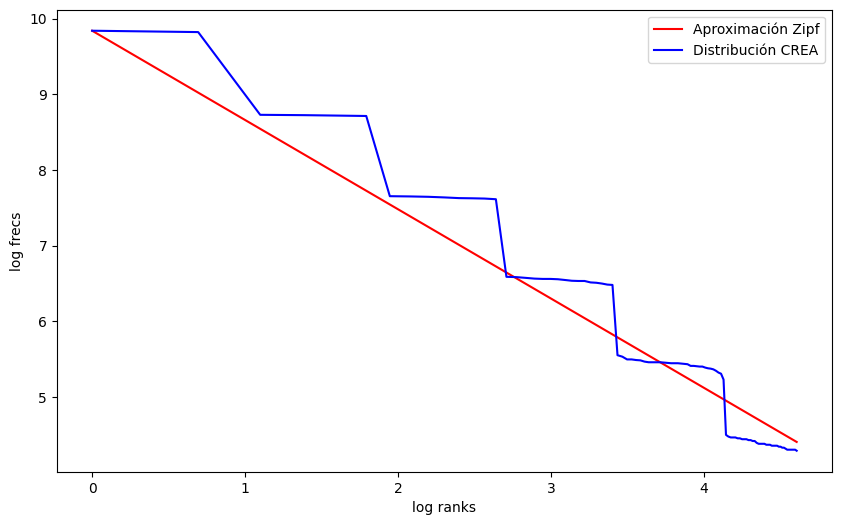

In [16]:
from scipy.optimize import minimize

ranks = np.array([i for i in range(len(frequencies))]) + 1
frecs = np.array(frequencies)

# Inicialización
a0 = 1

# Función de minimización:
func = lambda a: sum((np.log(frecs)-(np.log(frecs[0])-a*np.log(ranks)))**2)

# Apliando minimos cuadrados
a_hat = minimize(func, a0).x[0]

print('alpha:', a_hat, '\nMSE:', func(a_hat))
def plot_generate_zipf(alpha: np.float64, ranks: np.array, freqs: np.array) -> None:
    plt.plot(np.log(ranks),  np.log(freqs[0]) - alpha*np.log(ranks), color='r', label='Aproximación Zipf')

plot_generate_zipf(a_hat, ranks, frecs)
plt.plot(np.log(ranks),np.log(frecs), color='b', label='Distribución CREA')
plt.xlabel('log ranks')
plt.ylabel('log frecs')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()


### Podemos notar que el valor de $\alpha$ es muy parecido al del corpues CREA que vimos en la práctica. También notamos que si está presente la tendencia de una linea recta! Esto apesar de haber inventado un lenguaje de manera artificial!

### También repetí el mismo ejercicio utilizando diferentes probabilidades para los caracteres del vocabulario y el resultado siempre seguía la misma tendencia, es muy sorprendente!

# Ejercicio 2: Realizar reconocimiento de entidades nombradas (NER) de HuggingFace

2. Explorar `datasets` del sitio [Hugging Face](https://huggingface.co/datasets) y elegir documentos de diferentes dominios en Español. Realizar reconocimiento de entidades nombradas (NER).
    - Pueden utilizar subconjuntos de los datasets encontrados
    - Mostrar resultados del reconocimiento
    - Una distribución de frecuencias de las etiquetas más comunes en cada dominio
    - Comentarios generales del desempeño observado.

*Sugerencias: Spacy, CoreNLP (puede ser cualquier otra herramienta)*

### Se inicializan las funcionalidades así como librerías necesarias, también una función que permite obtener histogramas con las etiquetas más comunes en cada dataset.

In [8]:
# Se debe reiniciar la sesión luego de correr por primera vez esta celda
# Y no hace falta correrla dos veces
!python -m spacy download es_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 21.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [9]:
from datasets import load_dataset
import spacy
import random
from collections import defaultdict
import matplotlib.pyplot as plt
from spacy import displacy

### Cargamos un pipeline especializado en Español

In [10]:
nlp = spacy.load("es_core_news_md")

### Estas son las ligas a las bases de datos de texto en Español

**Sonetos de la era dorada**

In [13]:
#https://huggingface.co/datasets/biglam/spanish_golden_age_sonnets

**Tweets**

In [14]:
#https://huggingface.co/datasets/pysentimiento/spanish-tweets

**Recopilación de Texto en Españo con 1.5 billones de palabras**

In [15]:
#https://huggingface.co/datasets/jhonparra18/spanish_billion_words_clean

**Chistes**

In [16]:
#https://huggingface.co/datasets/mrm8488/CHISTES_spanish_jokes

### Se cargan los documentos en forma de data

In [17]:
Data_Sonetos = load_dataset("biglam/spanish_golden_age_sonnets",trust_remote_code=True)
Data_Tweets = load_dataset("alexfabbri/multi_news",trust_remote_code=True)
Data_BillionWords = load_dataset("alexfabbri/multi_news",trust_remote_code=True)
Data_Chistes = load_dataset("mrm8488/CHISTES_spanish_jokes",trust_remote_code=True)

README.md:   0%|          | 0.00/4.86k [00:00<?, ?B/s]

spanish_golden_age_sonnets.csv:   0%|          | 0.00/4.34M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5077 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

multi_news.py:   0%|          | 0.00/3.83k [00:00<?, ?B/s]

train.src.cleaned:   0%|          | 0.00/548M [00:00<?, ?B/s]

train.tgt:   0%|          | 0.00/58.8M [00:00<?, ?B/s]

val.src.cleaned:   0%|          | 0.00/66.9M [00:00<?, ?B/s]

val.tgt:   0%|          | 0.00/7.30M [00:00<?, ?B/s]

test.src.cleaned:   0%|          | 0.00/69.0M [00:00<?, ?B/s]

test.tgt:   0%|          | 0.00/7.31M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/44972 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5622 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5622 [00:00<?, ? examples/s]

### Veamos como se ve el etiquetado de algunos chistes

In [26]:
cc=list(nlp.pipe(Data_Chistes["train"]['text']))

In [27]:
displacy.render(cc[1:10], style="ent")

/usr/local/lib/python3.11/dist-packages/spacy/displacy/__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


### Definimos una función para crear los histogramas de las categorías más comunes

In [20]:
def Hist_NER(data,column,ax,K=100):

    Dict_NER = defaultdict(int)
    corpus = random.choices(data["train"][column], k=K)
    docs = list(nlp.pipe(corpus))
    for j, doc in enumerate(docs):
        for i, ent in enumerate(doc.ents):
            Dict_NER[ent.label_] += 1

    sorted_items = sorted(Dict_NER.items(), key=lambda item: item[1], reverse=True)
    sorted_keys = [item[0] for item in sorted_items]
    sorted_values = [item[1] for item in sorted_items]

    ax.bar(sorted_keys, sorted_values)
    ax.set_xlabel("Names")
    ax.set_ylabel("Frequency")
    ax.set_title("Frequency Distribution")
    # Adjust x-tick labels if needed (e.g., rotate them if they're long)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")


### Gráfico con los histogramas de 4 campos distintos: Sonetos de la época dorada de México, Tweets, Billion words, y de Chistes.

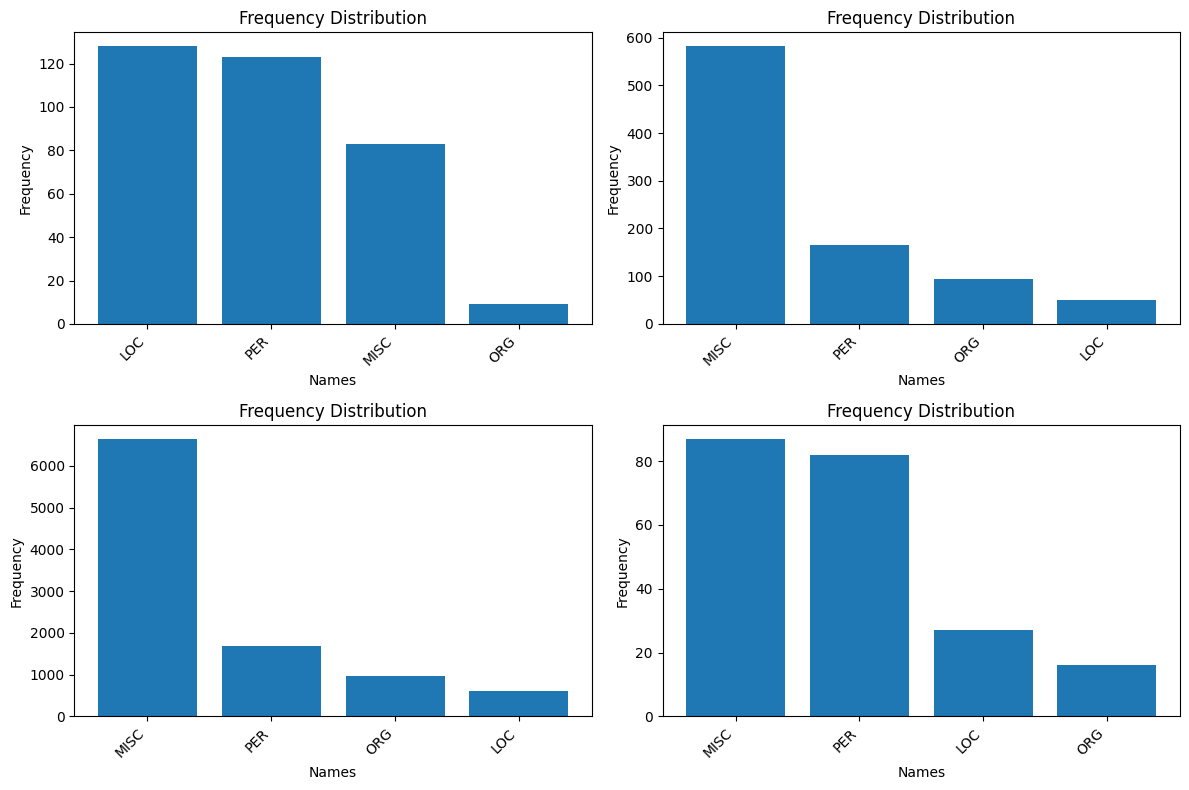

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
# Plot the histograms on each subplot
Hist_NER(Data_Sonetos, 'sonnet_text', axes[0, 0])
Hist_NER(Data_Tweets, 'document', axes[0, 1], K=10)
Hist_NER(Data_BillionWords, 'document', axes[1, 0], K=50)
Hist_NER(Data_Chistes, 'text', axes[1, 1])

# Adjust layout to prevent overlapping titles and labels
plt.tight_layout()
plt.show()

### Explicación de cada categoría

In [22]:
spacy.explain("MISC")

'Miscellaneous entities, e.g. events, nationalities, products or works of art'

In [23]:
spacy.explain("PER")

'Named person or family.'

In [24]:
spacy.explain("ORG")

'Companies, agencies, institutions, etc.'

In [25]:
spacy.explain("LOC")

'Non-GPE locations, mountain ranges, bodies of water'

## Conclusiones

### Lo que más me llamó la atención son las muy pocas categorías que existen en el pipeline de Spacy en Español comparado con las que vimos en clase para el Inglés. Creo que aún hya una gran diferencia.

### La reducida cantidad de categorías se debe a que muchas categorías que están divididas en el Inglés no aparecen así en el Español. Esto hace que sea más difícil crear un etiquetado específico.


